In [1]:
from data import Data
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

Strategy
-

RNN model we developed works ignoring the noise. This can be ideal if the noise is actually noise. However, if 'noise' carries a meaning which we would like to capture,  we can do this by increasing the hidden states and adding multiple layers. 

Here, we will employ a different method. First, we capture periodicity by RNN and then, capture the noise with an LSTM model. 

In [ ]:
class RNN_model(nn.Module):
    def __init__(self, num_inputs, num_hiddens,num_out=1):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.rnn = nn.RNN(num_inputs, num_hiddens, bias=False)
        self.linear = nn.Linear(num_hiddens, num_out, bias=False)
    def forward(self, X, H):
        X_0 = torch.zeros(len(X),1)
        X_0[0] = 1.
        state, H = self.rnn(X_0,H)
        pred = self.linear(state)
        return pred, H, state #Return state to analyze the state space

In [5]:
def rnn_train(model, X, optimizer, criterion, H, epoch):
    model.train()
    optimizer.zero_grad()
    y_hat,H, state = model(X, H)
    loss = criterion(X,y_hat)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(torch.sqrt(loss.detach()))

In [6]:
data = Data(0.1,100,0.2)
X = data.x.unsqueeze(-1)
mse_loss = nn.MSELoss()
rnn_model = RNN_model(1,2) #hidden state of size 2 is enough for sin
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.01)
for epoch in range(5000):
    H = torch.zeros(1,2)
    rnn_train(rnn_model, X, optimizer, mse_loss, H, epoch)

tensor(0.7368)
tensor(0.1719)
tensor(0.1711)
tensor(0.1719)
tensor(0.1711)


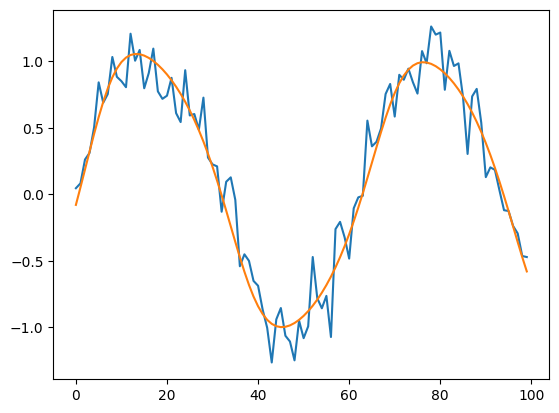

In [25]:
X_zeros = torch.zeros(100,1)
H = torch.zeros(1,2)
rnn_out,H_first_out, states = rnn_model(X_zeros,H)
rnn_out = rnn_out.detach()
plt.plot(X)
plt.plot(rnn_out)

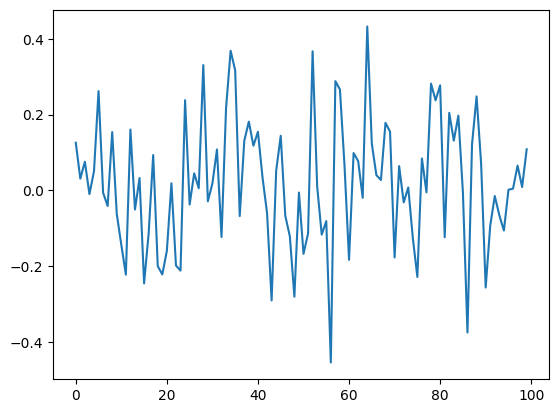

In [26]:
pure_noise = X-rnn_out
plt.plot(pure_noise)

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, num_inputs, num_hiddens,num_out=1):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.LSTM = nn.LSTM(num_inputs, num_hiddens, bias=False)
        self.linear = nn.Linear(num_hiddens, num_out, bias=False)
    def forward(self, X, H, c):
        X_0 = torch.zeros(len(X),1)
        X_0[0] = 1.
        out, (H, c) = self.LSTM(X_0,(H,c))
        pred = self.linear(out)
        return pred, H

In [28]:
def train(model, X, optimizer, criterion, H, c, epoch):
    model.train()
    optimizer.zero_grad()
    y_hat, H = model(X, H, c)
    loss = criterion(X,y_hat)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(torch.sqrt(loss.detach()))

In [33]:
mse_loss = nn.MSELoss('sum')
lstm_model = LSTM_model(1,40)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
for epoch in range(20000):
    H = torch.zeros(1,40)
    c = torch.zeros(1,40)
    train(lstm_model, pure_noise, optimizer, mse_loss, H, c,epoch)

tensor(0.1709)
tensor(0.1683)
tensor(0.1242)
tensor(0.1111)
tensor(0.1258)
tensor(0.1020)
tensor(0.0815)
tensor(0.0419)
tensor(0.1087)
tensor(0.0892)
tensor(0.0815)
tensor(0.0650)
tensor(0.0386)
tensor(0.0229)
tensor(0.0166)
tensor(0.0145)
tensor(0.0092)
tensor(0.0258)
tensor(0.0079)
tensor(0.0049)


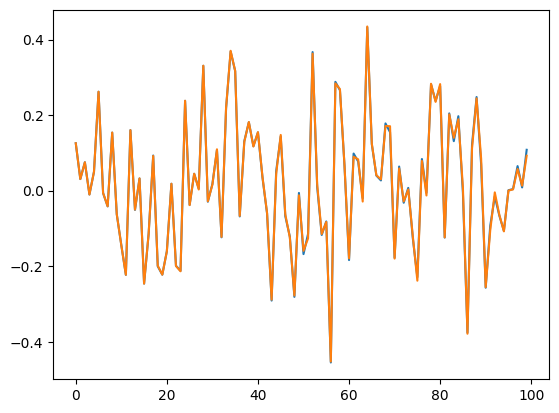

In [34]:
H = torch.zeros(1,40)
c = torch.zeros(1,40)
noise_out,H_lstm_out = lstm_model(pure_noise,H,c)
noise_out=noise_out.detach()
plt.plot(pure_noise)
plt.plot(noise_out)

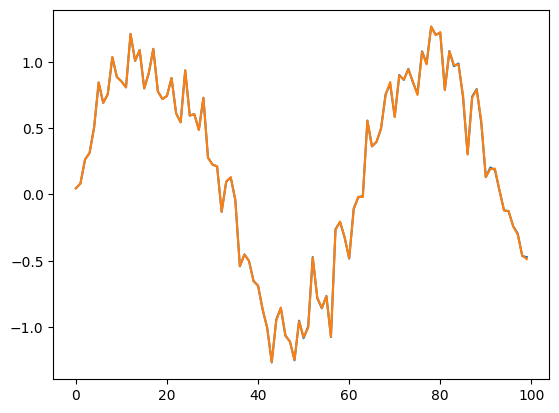

In [35]:
plt.plot(X)
plt.plot(rnn_out+noise_out)

Surprizingly perfect fitting! Let's see prediction for unseen data.

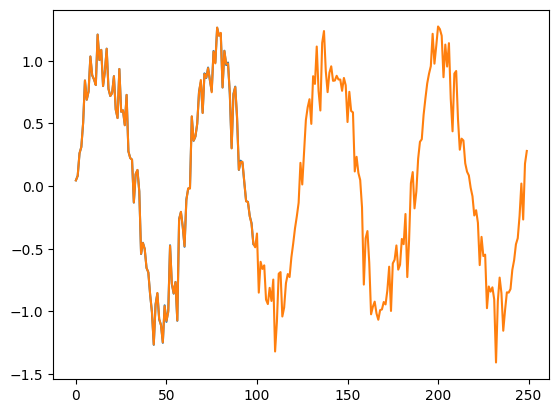

In [39]:
X_zeros = torch.zeros(250,1)
H_in_rnn = torch.zeros(1,2)
X1,H1,s = rnn_model(X_zeros,H_in_rnn)
X1 = X1.detach()

H_in_LSTM = torch.zeros(1,40)
c = torch.zeros(1,40)
X2,H2 = lstm_model(X_zeros,H_in_LSTM,c)
X2 = X2.detach()
X_final = X1+X2

plt.plot(X)
plt.plot(X_final)